# Human Microbiome Project

Data for the analysis was obtained through the Human Microbiome Project, a National Institute of Health (NIH) project that aims to characterize the human microbiome with the purpose of understanding the relationship between microbial communities in our bodies and their role in human health and disease. 

The dataset labeled projects as 'Complete' and 'In Progress' so after analyzing and summarizing interesting insights into the projects, a logistic regression model was trained to predict project completion. 

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
microbiome = pd.read_csv("/Users/jesus/Documents/Data_Science_Projects/Human_Microbiome_Project/project_catalog.csv")

In [4]:
microbiome_working = microbiome.copy()
microbiome_working['Genus'] = microbiome_working['Organism Name'].str.split(' ').str[0]

# Exploratory Data Analysis

## Four Domains are represented in the dataset: 
* Bacterial
* Eukaryal
* Virus
* Archaeal

In [76]:
microbiome_working['Domain'].value_counts()

BACTERIAL    2696
EUKARYAL        8
VIRUS           6
ARCHAEAL        2
Name: Domain, dtype: int64

## Pathogenic fungi and yeast are Eukaryotes present in the dataset 
The fungi and yeast in the dataset are predominantly opportunistic pathogens. These organisms would not normally cause disease in a host, but can do so if certain conditions like immunodefiecncy occur. 

In [77]:
microbiome_working[microbiome['Domain'] == 'EUKARYAL'][['Organism Name', 'HMP Isolation Body Site']]

,Organism Name,HMP Isolation Body Site
601,Exophiala dermatitidis NIH/UT8656,unknown
983,Phialophora europaea CBS 101466,skin
985,Mucor circinelloides f. circinelloides 1006PhL,skin
999,Pichia kudriavzevii CAB39-6420,blood
1065,Sporothrix schenckii ATCC 58251,wound
2555,Candida glabrata CAB52-4041,airways
2556,Candida tropicalis CAB54-6763-3,blood
2557,Candida parapsilosis CAB50-2638,blood


## Phages represent the viral organisms recovered in the dataset
Phages are viral organisms that selectively infect and replicate within bacteria and archea. The organism name is a reference to the specific bacteria the phage targets. There is a phage that targets Actinomyces and five different phages that target Pseudomonas. 

In [78]:
microbiome_working[microbiome['Domain'] == 'VIRUS'][['Organism Name', 'HMP Isolation Body Site']]

,Organism Name,HMP Isolation Body Site
532,Actinomyces phage vB_Ana_GK1,unknown
2852,Pseudomonas phage F_HA0480sp/Pa1651,unknown
2853,Pseudomonas phage JBD18,unknown
2854,Pseudomonas phage JBD25,unknown
2855,Pseudomonas phage JBD26,unknown
2856,Pseudomonas phage JBD67,unknown


## The only representative of the Archaeal domain is Methanobrevibacter smithii, which is the predominant archeon in the human gut microbiome
Archea were previously classified as bacteria but now the domain is a separate one. Members of the domain are unique as many are found in extreme environments including extreme temperatures, salt concentrations or high pressure. The ability of surviving such conditions has led to many archeans to be labeled as "extremophiles".

In [79]:
microbiome_working[microbiome['Domain'] == 'ARCHAEAL'][['Organism Name', 'HMP Isolation Body Site']]

,Organism Name,HMP Isolation Body Site
302,Methanobrevibacter smithii DSM 2374,gastrointestinal_tract
303,Methanobrevibacter smithii DSM 2375,gastrointestinal_tract


# Projects
There are different institutions contributing to the Human Microbiome Project. There are a total of 2915 projects in the dataset. Below is a list of the institutions and the number of projects for each in the dataset. Washington University Genome Sequencing Center has 1370, the highest number from all of the sequencing centers. 

In [80]:
microbiome_working['Sequencing Center'].value_counts()

Washington University Genome Sequencing Center    1370
Broad Institute                                    746
J. Craig Venter Institute                          507
Baylor College of Medicine                         190
Sanger Institute                                    35
NIH Intramural Sequencing Center (NISC)             32
Univ of Tokyo                                       29
Virginia Commonwealth Univ                           1
Wakayama Medical Univ                                1
Name: Sequencing Center, dtype: int64

It was noted that the projects in the dataset were labeled as 'Complete' or 'In Progress,' with only complete projects reporting gene counts. About 54.2% of the projects are 'Complete' and 45.8% are still 'In Progress. The Washington University Genome Sequencing Center has over 700 'In Progress' projects, which accounts for around 57.1% of projects that are still not completed. 

[Text(0.5, 1.0, 'Only Complete Projects Report Gene Count')]

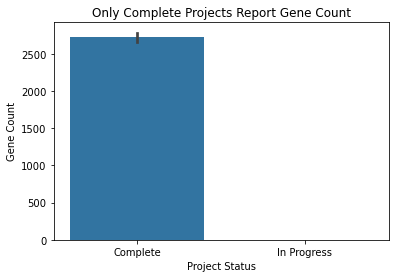

In [81]:
sns.barplot(data = microbiome_working, 
            x = 'Project Status', 
            y = 'Gene Count').set(title='Only Complete Projects Report Gene Count')

* 'Complete' and 'In Progress' projects

In [82]:
microbiome_working['Project Status'].value_counts(normalize=True)*100

Complete       54.168096
In Progress    45.831904
Name: Project Status, dtype: float64

[Text(0.5, 1.0, 'In Progress Projects per Sequencing Center')]

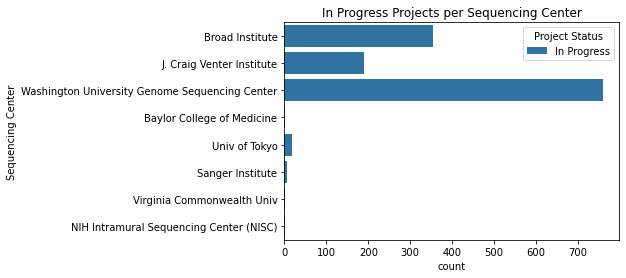

In [83]:
in_progress = microbiome_working[microbiome_working['Project Status']=='In Progress']
sns.countplot(data = in_progress, 
              y = 'Sequencing Center', 
              hue = 'Project Status').set(title='In Progress Projects per Sequencing Center')

In [84]:
in_progress['Sequencing Center'].value_counts(normalize=True)*100

Washington University Genome Sequencing Center    57.057057
Broad Institute                                   26.501502
J. Craig Venter Institute                         14.264264
Univ of Tokyo                                      1.426426
Sanger Institute                                   0.450450
NIH Intramural Sequencing Center (NISC)            0.150150
Baylor College of Medicine                         0.075075
Virginia Commonwealth Univ                         0.075075
Name: Sequencing Center, dtype: float64

Aside from overall project progress, the data did provide further detail on the current finishing level. Not all 'Completed' projects were completely finished. Projects appeared to be at the draft stage, but showed a high degree of quality.

[Text(0.5, 1.0, 'Most projects are Level 3: Improved High Quality Drafts')]

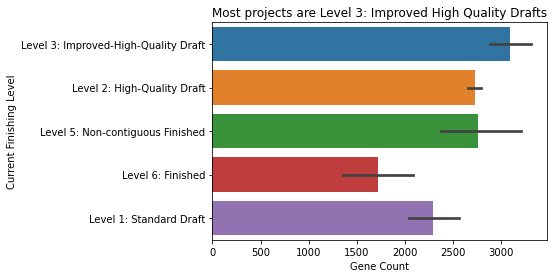

In [85]:
sns.barplot(data = microbiome_working, 
            x = 'Gene Count' , 
            y = 'Current Finishing Level').set(title='Most projects are Level 3: Improved High Quality Drafts')

A substantial number of projects in the data are from the gastrointestinal tract and come from the Washington University Genome Sequencing Center. The skin was one of the isolation sites associated with the projects and the majority of them were from the Washington University Genome Sequencing Center.

<AxesSubplot:ylabel='Sequencing Center,HMP Isolation Body Site'>

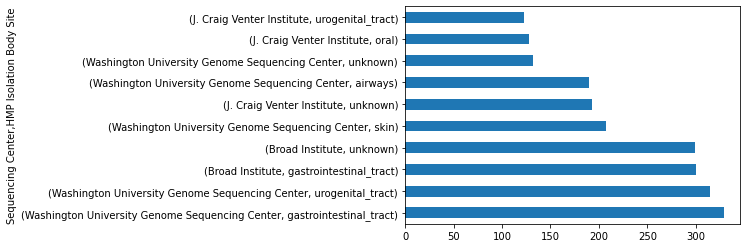

In [86]:
microbiome_working.groupby('Sequencing Center')['HMP Isolation Body Site'].value_counts().sort_values().nlargest(10).plot(kind='barh')

[Text(0.5, 1.0, 'Skin Projects per Sequencing Center')]

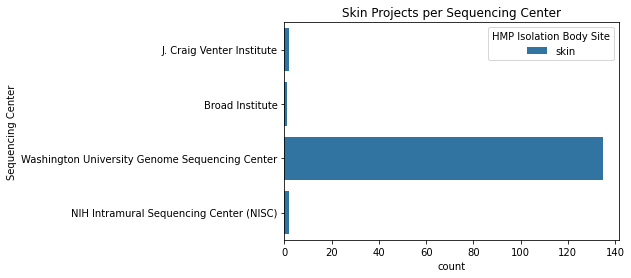

In [87]:
skin_projects = microbiome_working[(microbiome_working['HMP Isolation Body Site']=='skin')&(microbiome_working['Project Status']=='In Progress')]
sns.countplot(data = skin_projects, 
              y = 'Sequencing Center', 
              hue = 'HMP Isolation Body Site').set(title='Skin Projects per Sequencing Center')

## Genes
The mean gene count was calculated to be 1474.62 and the median 1517, both similar values to represent a typical gene count in the dataset. 

[Text(0.5, 1.0, 'Distribution of gene counts for complete projects vs in-progress')]

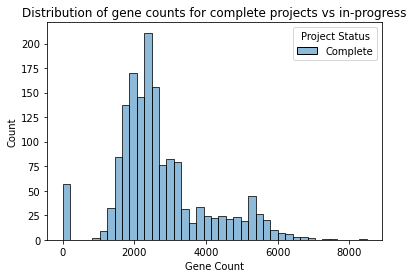

In [88]:
sns.histplot(data=microbiome_working[microbiome_working['Project Status']=='Complete'], 
             x = 'Gene Count', 
             hue='Project Status').set(title='Distribution of gene counts for complete projects vs in-progress')

In [89]:
microbiome_working[['Gene Count']].describe()

,Gene Count
count,2915.000000
mean,1474.622642
std,1653.762393
min,0.000000
25%,0.000000
50%,1517.000000
75%,2489.500000
max,8490.000000


In [90]:
microbiome_working[['Gene Count']].median()

Gene Count    1517.0
dtype: float64

## Analysis

* Streptomyces sp. HGB0020 was the organism with the highest gene count in the data
* Streptococcus is the most recovered organism
* The gastrointestinal tract appears to show a high degree of diversity 
* Grouping by genus and isolation site shows that one of the most widely recovered organisms was Staphylococcus in the urogentical tract
* Staphylococcus was recovered in over eight different body sites

In [91]:
microbiome_working.iloc[microbiome_working['Gene Count'].idxmax()]['Organism Name']

'Streptomyces sp. HGB0020'

[Text(0.5, 1.0, 'Streptomyces sp. HGB0020 has the highest gene count')]

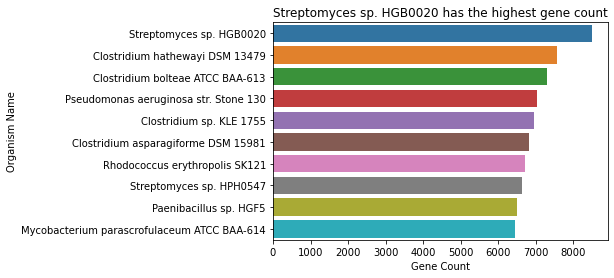

In [92]:
sns.barplot(data=microbiome_working.sort_values(by='Gene Count', ascending=False).head(10), 
            x='Gene Count', 
            y='Organism Name').set(title='Streptomyces sp. HGB0020 has the highest gene count')

<AxesSubplot:title={'center':'Streptococcus is the most widely recovered organism'}>

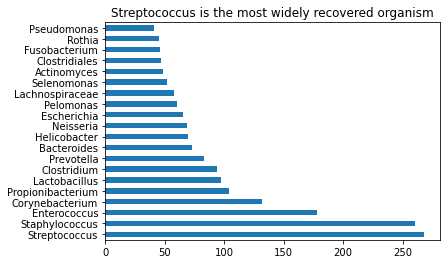

In [93]:
microbiome_working['Genus'].value_counts().head(20).plot(kind='barh',
                                                        title= 'Streptococcus is the most widely recovered organism')

[Text(0.5, 1.0, 'High Gastrointestinal Diversity')]

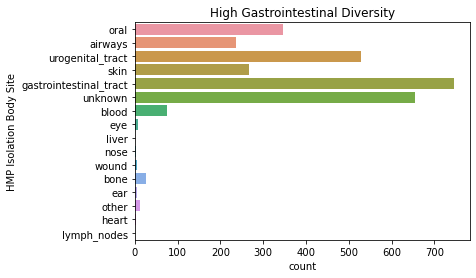

In [94]:
sns.countplot(data = microbiome_working, 
              y = 'HMP Isolation Body Site').set(title='High Gastrointestinal Diversity')

<AxesSubplot:title={'center':'Staphylococcus widely recovered in the urogentical tract'}, ylabel='Genus,HMP Isolation Body Site'>

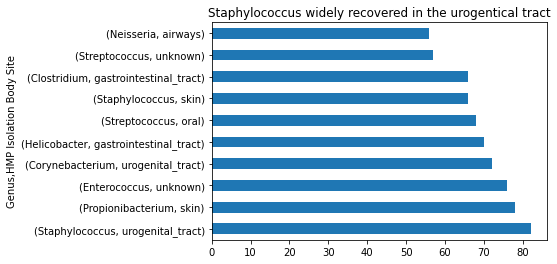

In [95]:
microbiome_working.groupby('Genus')['HMP Isolation Body Site'].value_counts().sort_values().nlargest(10).plot(kind='barh', title='Staphylococcus widely recovered in the urogentical tract')                                                                                               

<AxesSubplot:title={'center':'Staphylococcus was recovered in over 10 isolation sites'}, ylabel='Genus'>

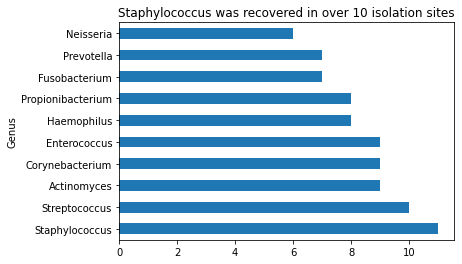

In [96]:
microbiome_working.groupby('Genus')['HMP Isolation Body Site'].nunique().sort_values().nlargest(10).plot(kind='barh', title='Staphylococcus was recovered in over 10 isolation sites')

# Logistic Regression Model: Determine the Project Status
A logistic regression model was used to predict the project status as it would be a binary classification, 'Completed' or 'In Progress', based on the variables 'Gene Count' and 'Current Finishing Level'. 

'Current Finishing Level' was categorical data with five different levels. One hot encoding was used to convert the categorical variable into the proper format for the logistic regression model and the project status was converted into binary format for prediction.
The range of the genus count was standardized 

In [97]:
microbiome_working['Current Finishing Level'].unique()

array(['Level 3: Improved-High-Quality Draft',
       'Level 2: High-Quality Draft', 'Level 5: Non-contiguous Finished',
       nan, 'Level 6: Finished', 'Level 1: Standard Draft'], dtype=object)

In [98]:
encoder = OneHotEncoder()
microbiome_encoded = microbiome_working.fillna('Other')
microbiome_encoded2 = microbiome_encoded[['Project Status','Gene Count', 'Current Finishing Level']]
coltrans = ColumnTransformer(transformers=[('encoder', 
                                            encoder,
                                            ['Current Finishing Level'])], remainder='passthrough')
microbiome_encoded2 = pd.DataFrame(coltrans.fit_transform(microbiome_encoded2))

In [99]:
#encoded project status to 0 and 1 
labenc = LabelEncoder()
microbiome_encoded2[6] = labenc.fit_transform(microbiome_encoded2[6])

In [100]:
#dropped 1 column 
microbiome_encoded2.drop([0], axis=1, inplace=True)

In [101]:
#scaled gene count 
scaler = MinMaxScaler()
microbiome_encoded2[[7]] = scaler.fit_transform(microbiome_encoded2[[7]])

In [102]:
microbiome_encoded2.head(5)

,1,2,3,4,5,6,7
0,0,1,0,0,0,0,0.229682
1,1,0,0,0,0,0,0.677856
2,0,0,1,0,0,0,0.707892
3,1,0,0,0,0,0,0.451355
4,1,0,0,0,0,0,0.427797


In [103]:
#split data into training and test
microbiome_X = microbiome_encoded2[[1,2,3,4,5,7]]
microbiome_y = microbiome_encoded2[[6]]

In [104]:
X_train,X_test,y_train,y_test=train_test_split(microbiome_X,microbiome_y,test_size=0.2,random_state=1842)

In [105]:
#fit the model 
model = LogisticRegression()
model.fit(X_train, y_train.values.ravel())

LogisticRegression()

A basic logistic regression model showed good performance in predicting the project status based on a confusion matrix. This apparent perfect performance of the model is probably an indicator that a model is not truly needed to predict project status. 'Gene counts' are only reported by 'Completed' projects and 'In Progress' projects are not labeled on draft quality unlike 'Completed' projects.

In [106]:
#made predictions using the model 
predictions = model.predict(X_test)
confusion_matrix(y_test, predictions)

array([[308,   0],
       [  0, 275]])

In [107]:
#accuracy of model
score = model.score(X_test, y_test)
print(score)

1.0


In [108]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       308
           1       1.00      1.00      1.00       275

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583

